### Project Objectives
- Document code, process, findings, and key takeaways.
- Make your process repeateable and your report (notebook) easy to read and follow.
- Ask exploratory questions of your data. Answer questions through charts and statistical tests.
- Construct a model to predict customer churn using classification techniques.
- Refine your work into a Report.
- Be prepared to answer panel questions.

### Business Goals
- Find drivers for customer churn at Telco. Why are customers churning?
- Construct a ML classification model that accurately predicts customer churn.
- Deliver a report that a non-data scientist can read through and understand what steps were taken, why and what was the outcome?

In [77]:
##imports

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from pydataset import data
import statistics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import sklearn
import prepare
import acquire

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_rows', 500)


First I acquire and do basic prep work on the data for processing

In [94]:
# calls prepare.py and utilized the prep_telco() function to return a prepared
# dataframe for telco, this automatically calls the acquire.py for acquisition
# of the csv and cleans/encodes the data for ease of processing/analysis
# then i have it run info and describe to manual review the information for any
# unusual data types or unexpected entries
prepare_df = prepare.prep_telco()
prepare_df.info(),prepare_df.describe(),prepare_df.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_id                            7043 non-null   object 
 1   senior_citizen                         7043 non-null   int64  
 2   tenure                                 7043 non-null   int64  
 3   monthly_charges                        7043 non-null   float64
 4   total_charges                          7043 non-null   float64
 5   gender_encoded                         7043 non-null   int64  
 6   partner_encoded                        7043 non-null   int64  
 7   dependents_encoded                     7043 non-null   int64  
 8   phone_service_encoded                  7043 non-null   int64  
 9   paperless_billing_encoded              7043 non-null   int64  
 10  churn_encoded                          7043 non-null   int64  
 11  mult

(None,
        senior_citizen       tenure  monthly_charges  total_charges  \
 count     7043.000000  7043.000000      7043.000000    7043.000000   
 mean         0.162147    32.371149        64.761692    2279.734304   
 std          0.368612    24.559481        30.090047    2266.794470   
 min          0.000000     0.000000        18.250000       0.000000   
 25%          0.000000     9.000000        35.500000     398.550000   
 50%          0.000000    29.000000        70.350000    1394.550000   
 75%          0.000000    55.000000        89.850000    3786.600000   
 max          1.000000    72.000000       118.750000    8684.800000   
 
        gender_encoded  partner_encoded  dependents_encoded  \
 count     7043.000000      7043.000000         7043.000000   
 mean         0.495244         0.483033            0.299588   
 std          0.500013         0.499748            0.458110   
 min          0.000000         0.000000            0.000000   
 25%          0.000000         0.0000

7043 records/observations, 32 columns/features.
In my prep file i encoded yes/no and 1 hot encoded anything with multiple values, dropping any duplicated or un-needed columns during that time.
My way of approach with the missing values in total_charges was to replace with a 0 rather than dropping.

i split my data to prevent contamination / bias, stratifying on target column (churn_encoded)

In [79]:
# sets my feature i want to predict/focus on
# splits my data twice with stratification on prediction feature
# returns the shapes for quick review

prediction_col = "churn_encoded"

train_df,test_df,validate_df = prepare.split_function(prepare_df.drop(columns=["customer_id"]),prediction_col)


prepared df shape: (7043, 31)
train shape: (4225, 31)
validate shape: (1409, 31)
test shape: (1409, 31)


I then seperate my data into churned and unchurned, categorical and numerical/quantifiable

In [96]:
##seperation of  data into easy referencing dataframes and lists (churned and unchurned. numbers and categories)

train_churned_df = train_df[train_df["churn_encoded"] == 1]
train_unchurned_df = train_df[train_df["churn_encoded"] == 0]

num_vars = []
cat_vars = []
for column in train_df:
    col_type =  train_df[column].dtype
    if col_type == "object":
        cat_vars.append(column)
    if col_type in ["int64", "uint8"] and ((train_df[column].max() + 1) / train_df[column].nunique())  == 1 :
        cat_vars.append(column)
    if col_type in ["float64", "int64", "uint8"] and \
        ((train_df[column].max() + 1) / train_df[column].nunique()) != 1 :
        num_vars.append(column)

## This section will be going over exploration

Now let's ask some questions of the data

Is churn dependant of payment type?

> - **Hypothesis 1 -**
> - alpha = .05
> - $H_0$: Is churn independant of payment type. $\mu_{churn}$ independent $\mu_{payment type}$ (pval > alpha).  
> - $H_a$: Rejection of Null $\mu_{virginica}$ ~~independent~~  $\mu_{versicolor}$ (pval <= alpha). 


Observed
[[789 774 780 761]
 [144 145 643 189]]
---
Expected
[[ 685.45136095  675.16591716 1045.44189349  697.9408284 ]
 [ 247.54863905  243.83408284  377.55810651  252.0591716 ]]
---
chi^2 = 388.9740, p = 0.00000, degf = 3 

due to p = 0.00000 < α = 0.05 we reject our null hypothesis
(  c̶h̶u̶r̶n̶_̶e̶n̶c̶o̶d̶e̶d̶ ̶i̶s̶ ̶i̶n̶d̶e̶p̶e̶n̶d̶a̶n̶t̶ ̶o̶f̶ ̶p̶a̶y̶m̶e̶n̶t̶s̶ )


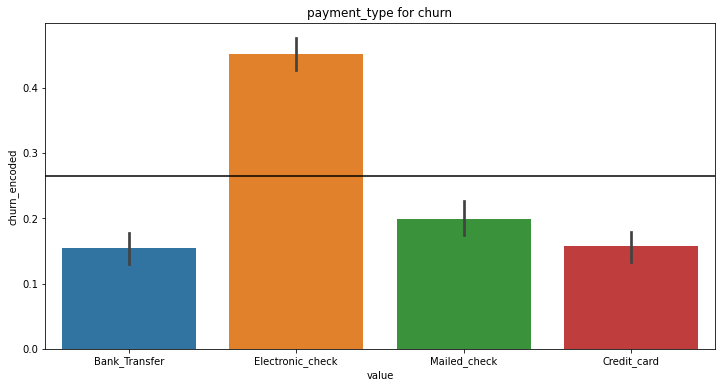

In [98]:
# creates a column of the payments for easy analysis, runs a crosstab to put into a chi2 independancy test.
# produces observed and expected values
# returns the chi2 and pval for the whole set

train_df["payments"] = np.where(train_df['payment_type_Credit card (automatic)'] == 1, "Credit_card", \
                                np.where(train_df['payment_type_Electronic check'] == 1, "Electronic_check", \
                                    np.where(train_df['payment_type_Mailed check'] == 1, "Mailed_check","Bank_Transfer")))

df1 = pd.crosstab(train_df.churn_encoded,train_df["payments"])
alpha = .05
chi2, p, degf, expected = stats.chi2_contingency(df1)
H0 = (f"{df1.index.name} is independant of {df1.columns.name}")
H1 = (f"{df1.index.name} is not independant of {df1.columns.name}")
print('Observed')
print(df1.values)
print('---\nExpected')
print(expected)
print(f'---\nchi^2 = {chi2:.4f}, p = {p:.5f}, degf = {degf} \n')
if p>alpha:
    print(f"due to p={p:.5f} > α={alpha} we fail to reject our null hypothesis\n({H0})")
else:
    print(f"due to p = {p:.5f} < α = {alpha} we reject our null hypothesis\n( ", '\u0336'.join(H0) + '\u0336' , ")")

#creates a melt dataframe on payments for churn and charts it
melt_list = ["payments","churn_encoded"]
melt = train_df[melt_list]
melt = melt.melt(id_vars="churn_encoded")
plt.figure(figsize=(12,6))
sns.barplot(x=melt.value, y=melt.churn_encoded,)
plt.title("payment_type for churn")
plt.axhline(train_df.churn_encoded.mean(), label="Mean line",color="black")
plt.show()

> - Outcome: Payments failed in the Chi^2 statistical test to pass the null hypothesis of being independant of churn. this would indicate that there's a relation.
A possiblity may be that someone who signs up for a Bank_Transfer has a more steady/long term requirement than someone who pays by Electronic check. Further investigation into tenure relating to payment type would be beneficial if i had more time.

Let's ask another question. Are those who pay more, more likely to churn?

> - **Hypothesis 2 -** 
> - alpha = .025
> - $H_0$: Is monthly payment less than or equal to  those who churned and than those who have not churn 
> - $\mu_{monthly payment (churned)} <= \mu_{monthly payment (retained)}$.
> -
> - $H_a$: Rejection of null 
> - $\mu_{monthly payment (churned)} > \mu_{monthly payment (retained)}$. 

we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=191.12029, p=0.00000

 We reject the null Hypothesis ( m̶o̶n̶t̶h̶l̶y̶ ̶p̶a̶y̶m̶e̶n̶t̶s̶ ̶o̶f̶ ̶c̶h̶u̶r̶n̶e̶d̶ ̶i̶s̶ ̶l̶e̶s̶s̶ ̶t̶h̶a̶n̶ ̶o̶r̶ ̶e̶q̶u̶a̶l̶ ̶t̶o̶ ̶m̶o̶n̶t̶h̶l̶y̶ ̶p̶a̶y̶m̶e̶n̶t̶s̶ ̶o̶f̶ ̶u̶n̶c̶h̶u̶r̶n̶e̶d̶ ) t=13.79648, p=0.00000


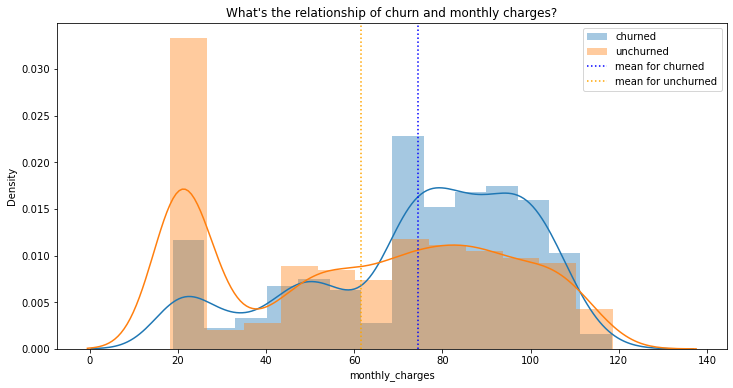

In [99]:
## does a levene test for comparing variance, creates a boolean flag that is passed into the ttest for
## comparing the churned monthly charge and the unchurned monthly charge
## then plots the graphs for a visual


H0 = "monthly payments of churned is less than or equal to monthly payments of unchurned"
Ha = "monthly payments of churned is greater than monthly payments of unchurned"
alpha = .025

#compare variances to know how to run the test
stat,pval = stats.levene(train_churned_df.monthly_charges,train_unchurned_df.monthly_charges)
stat,pval
if pval > 0.05:
    equal_var_flag = True
    print(f"we can accept that there are equal variance in these two groups with {round(pval,2)} certainty Flag=T",'stat=%.5f, p=%.5f' % (stat,pval))
else:
    equal_var_flag = False
    print(f"we can reject that there are equal variance in these two groups with {round((1-pval),2)} certainty Flag=F",'stat=%.5f, p=%.5f' % (stat,pval))


t, p = stats.ttest_ind( train_churned_df.monthly_charges, train_unchurned_df.monthly_charges, equal_var = equal_var_flag )

if p > alpha or t < 0: #directionality, or if t is negative
    print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
else:
     print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))

plt.figure(figsize=(12,6))
plt.title("What's the relationship of churn and monthly charges?")
sns.distplot(train_churned_df.monthly_charges,label="churned")
sns.distplot(train_unchurned_df.monthly_charges,label="unchurned")
plt.axvline(train_churned_df.monthly_charges.mean(),color="blue",ls=":",label="mean for churned")
plt.axvline(train_unchurned_df.monthly_charges.mean(),color="orange",ls=":",label="mean for unchurned")
plt.legend()
plt.show()


> - Outcome: we do find enough evidence to statistically reject the null hypothesis ~~(monthly payments for those who churn are less than or equal to those who have not churned)~~
> - This is not surprising, though it could be linked to a number of possibilities (paying for and possibily being unhappy with un-needed/unused services). Further investigation into this would also be beneficial.

> - **Question 3 -** 
> - Which additional service provided has the highest churn?

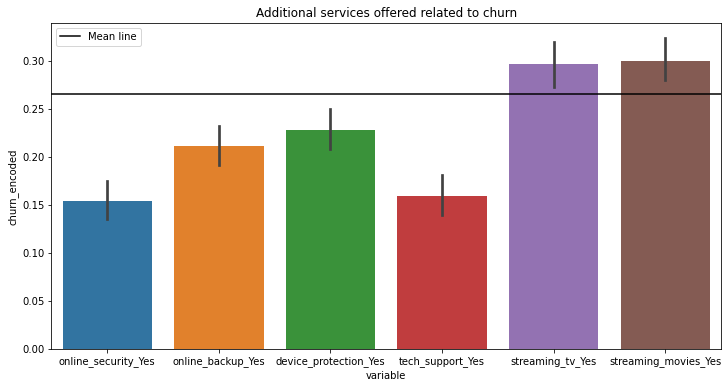

variable
streaming_movies_Yes    0.29982
Name: churn_encoded, dtype: float64


In [84]:
## creates a melt based on services provided and produced a chart based on the mean of churn for each category in services

service_list =['online_security_Yes', 'online_backup_Yes',
       'device_protection_Yes', 'tech_support_Yes', 'streaming_tv_Yes',
       'streaming_movies_Yes',"churn_encoded"]
melt = train_df[service_list]
melt = melt.melt(id_vars="churn_encoded")
melt = melt[melt.value == 1 ]
plt.figure(figsize=(12,6))
sns.barplot(x=melt.variable, y=melt.churn_encoded,)
plt.title("Additional services offered related to churn")
plt.axhline(train_df.churn_encoded.mean(), label="Mean line",color="black")
plt.legend()
plt.show()
#print(melt.groupby("variable")["churn_encoded"].mean())
#print("-----------------")
print(melt.groupby("variable")["churn_encoded"].mean().nlargest(1))

> - Outcome: Here we can see that those who subscribe to streaming movies (and TV) are services subscribed to the most among those who churn. Maybe there is a cheaper/better value option available to customers offered elsewhere?


> - **Question 4 -** 
> - When (in terms of tenure) are people most likely to churn?

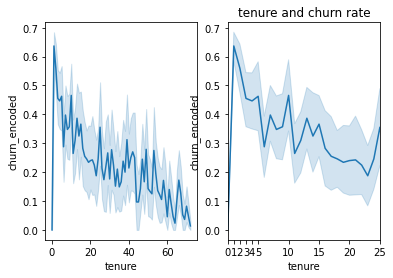

In [85]:
## creates two subplots that are of the churn ratio over time. the first is all of the time period provided in the data
## the second is "zoomed in" on the first 2 years (25 periods)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)

sns.lineplot(x=train_df["tenure"], y=train_df[prediction_col], data=train_df, ax=ax1)
plt.title(f"tenure and churn rate")

second_plt =sns.lineplot(x=train_df["tenure"], y=train_df[prediction_col], data=train_df, ax=ax2)
plt.title("tenure and churn rate")
second_plt.set_xlim(0,24)
plt.xticks([0,1,2,3,4,5,10,15,20,25])
plt.show()

> - Outcome: highest churn to be found at the first month, a bump near the 1 year contract end, as well as a rise again near the 2 year contract term.
> - This could be related to customers trying the services and then going elsewhere.

---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---

# Modeling

In [86]:
##find the baseline of churn based on mode
baseline_predict = train_df[prediction_col].mode()[0]
(train_df[prediction_col] == baseline_predict).mean()

print(f"{baseline_predict} <--- mode of survived in training data / baseline prediction")
print(f"{(train_df[prediction_col] == baseline_predict).mean() * 100 :.2f}% <--- accuracy of baseline prediciton in training data")


0 <--- mode of survived in training data / baseline prediction
73.47% <--- accuracy of baseline prediciton in training data


### **73.47% baseline prediction accuracy on training data**

-
-
-
-
-
-
-
-
-
-

we see there are a lot of categories, so we will go through and perform an independance test. we'll use pval to drop those with "statistically significant" likelyhood of dependance. 

we will be using relatively low pval due to wanting only the most independant features

In [87]:
## in an attempt to reduce features i go through the features i deemed
# categorical and make a DF of their results from Chi^2 and remove those
# that have low independance of Churn
## to reduce further i remove the bottom 25% through evaluation of Chi^2 values

cat_df = pd.DataFrame({"col_name":[],"p_val":[],"chi2_val":[]})
for iter1 in cat_vars:

    var_x = train_df[iter1]
    var_y = train_df.churn_encoded
    df1 = pd.crosstab(var_x,var_y)
    chi2, p, degf, expected = stats.chi2_contingency(df1)

    cat_df.loc[len(cat_df.index)] = [var_x.name,p,chi2]

cat_dep_df = cat_df[cat_df["p_val"] < .05]

cat_high_dep_df = cat_dep_df[cat_dep_df.chi2_val > cat_dep_df.chi2_val.quantile(.25)]
cat_high_dep_df = cat_high_dep_df[cat_high_dep_df.col_name != "churn_encoded"]


Splitting the data into training sets for modeling

In [88]:
##setting the data sets based on features i want to include
X_train = train_df[train_df.columns.intersection([ele for ele in cat_high_dep_df.col_name])]
y_train = train_df[prediction_col]

X_validate = validate_df[validate_df.columns.intersection([ele for ele in cat_high_dep_df.col_name])]
y_validate = validate_df[prediction_col]

X_test = test_df[test_df.columns.intersection([ele for ele in cat_high_dep_df.col_name])]
y_test = test_df[prediction_col]

doing the modeling

Text(0.5, 1.0, 'weight of features/feature importance to Random Forest')

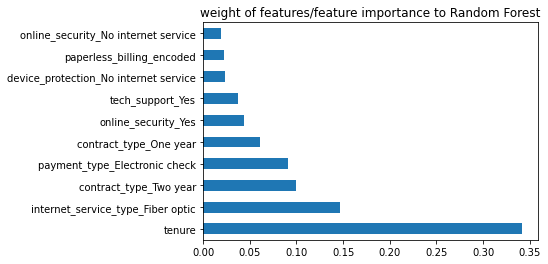

In [89]:
## doing a basic decison tree classification
## fits the model, plots it, predicts off the training, and produces results (classification and confusion matrix)

clf = DecisionTreeClassifier(max_depth= 4, random_state= 123, criterion="gini")
clf = clf.fit(X_train,y_train)

y_pred_train_dt = clf.predict(X_train)

y_pred_val_dt = clf.predict(X_validate)
#############################################

## logistic regression classifier, played with values until i found some i liked
## produces confusion and classification reports

logreg = LogisticRegression(C=.1)#, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs', max_iter=1000000000)
logreg.fit(X_train,y_train)

y_pred_train_array = logreg.predict(X_train)

y_pred_logreg_val = logreg.predict(X_validate)
#############################################

## random forest classifier, i played with the values until i settled on these
## fits the data, predicts on the training, and runs classification and confusion reports
## also plots the most weight of the top 10 features with a confusion matrix display below it

rf = RandomForestClassifier(bootstrap=True,class_weight=None,criterion="gini",min_samples_leaf=5,n_estimators=100,max_depth=7,random_state=123)
rf.fit(X_train,y_train)

y_pred_rf = rf.predict(X_train)

y_pred_rf_val = rf.predict(X_validate)

pd.Series(rf.feature_importances_, index=X_train.columns).nlargest(10).plot(kind='barh')
plt.title("weight of features/feature importance to Random Forest")

ran a barchart of the feature weight/feature importance to verify earlier exploration. we can see here a key feature to have investigated would have been Fiber Optic

Review and Select the best models

In [90]:
print(classification_report(y_validate, y_pred_val_dt), "\t Decision Tree classification report on validate set")
print("----------------")
print(classification_report(y_validate, y_pred_rf_val),"\t Random Forest validate classification report")
print("----------------")
print(classification_report(y_validate, y_pred_logreg_val),"\t Logistic Regression validate classification")

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1035
           1       0.69      0.49      0.57       374

    accuracy                           0.80      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409
 	 Decision Tree classification report on validate set
----------------
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409
 	 Random Forest validate classification report
----------------
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1035
           1       0.66      0.55      0.60       374

    accuracy                           0.81    

-
-
-
-
-
-
-
-
-
-

## Opting to use RandomForest for the final test predictions
- almost all the model performances where similar to each other, so I used the one with the best balance of precision and recall

In [91]:
## running the test set using my randomforest classifier
## produces confusion, classifification report as well as probabilities

y_pred_rf_test = rf.predict(X_test)
y_proba_rf_test = rf.predict_proba(X_test)
print(confusion_matrix(y_test, y_pred_rf_test), "confusion matrix")
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))
print("----------")
print(classification_report(y_test, y_pred_rf_test),"\t test classification report")


[[927 108]
 [168 206]] confusion matrix
Accuracy of random forest classifier on test set: 0.80
----------
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1035
           1       0.66      0.55      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409
 	 test classification report


The recall and precision (on positive cases) are less than i would like to see, but similar to our validation set

i then move data over and around to export out the csv

In [92]:
#i keep everything in X_test to retain the index for match with customer_id, adding in probablity and prediction
# removes the data that was not in it prior through tranposing and using tail, and pushes that out a csv

X_test["1_proba"] = pd.DataFrame(y_proba_rf_test,columns=["0_proba","1_proba"])["1_proba"].values
X_test["prediction"] = y_pred_rf_test
X_test["customer_id"] = prepare_df.customer_id
X_test.T.tail(3).T.to_csv("predictions.csv")
X_test.T.tail(3).T

,1_proba,prediction,customer_id
3160,0.1389,0,4531-AUZNK
1577,0.040829,0,2296-DKZFP
6823,0.473283,0,9692-TUSXH
3615,0.425081,0,5129-JLPIS
882,0.702389,1,1273-MTETI
...,...,...,...
1097,0.410767,0,1597-FZREH
6441,0.587297,1,9117-SHLZX
5985,0.01581,0,8441-SHIPE
2452,0.027278,0,3511-BFTJW


# IN CONCLUSION
- #### There are many relations to churn and the drivers that cause it
- Payment Type: Those who pay with electronic check churned most.
- Tenure: Those who are within the first few months or near end of contract are likely to churn.
- Monthly Cost: Those who pay more are more likely to churn.
- Additional Services Provided: Need better movies and tv shows?
- Core services provided: We see in feature weight for churn that those who subscribe to Fiber were among the top of the list

## Key Takeaway
- Customers are looking for non-commitment, high value/low cost, and they want it fast. 

## Next Steps
- Customer surveys would be beneficital
- Go back and review further in depth why electronic check users are more likely to churn than others
- Go back and review the costs of the Movies and TV shows related to others
- Understand why Fiber users had a high relation to churn